# Frequency and time-frequency sensors analysis


The objective is to show you how to explore the spectral content
of your data (frequency and time-frequency). Here we'll work on Epochs.

    Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
             Stefan Appelhoff <stefan.appelhoff@mailbox.org>
             Richard Höchenberger <richard.hoechenberger@gmail.com>
             Denis A. Engemann <denis.engemann@gmail.com>
    License: BSD (3-clause)

In [1]:
%matplotlib qt
import os

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

Set parameters



In [2]:
mne.set_log_level('WARNING')

# Change the following path to where the folder ds000117-practical is on your disk
data_path = os.path.expanduser("~/work/data/ds000117-practical/")

raw_fname = os.path.join(data_path,
    'derivatives/meg_derivatives/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_proc-sss_meg.fif')

epochs_fname = raw_fname.replace('_meg.fif', '-epo.fif')

In [3]:
epochs = mne.read_epochs(epochs_fname)
epochs

<EpochsFIF  |   79 events (all good), -0.2 - 2 sec, baseline [-0.2, 0], ~157.9 MB, data loaded,
 'face/famous/first': 13
 'face/famous/immediate': 3
 'face/famous/long': 6
 'face/unfamiliar/first': 17
 'face/unfamiliar/immediate': 4
 'face/unfamiliar/long': 6
 'scrambled/first': 15
 'scrambled/immediate': 9
 'scrambled/long': 6>

In [4]:
# epochs.resample(200., npad='auto')  # resample to reduce computation time

Frequency analysis
------------------

We start by exploring the frequence content of our epochs.



Let's first check out all channel types by averaging across epochs.



In [5]:
epochs.plot_psd(fmin=2., fmax=40., average=False, bandwidth=2);

<div class="alert alert-info">
    <b>REMARK</b>:
     <ul>
    <li> Select a frequenct range in the plot to inspect topographies</li>

<li> The "bandwidth" parameter controls the spectral resolution of the multitaper. You can increase the resolution by chosing a narrower bandwidth at the cost of longer computation time.</li>
    </ul>
</div>

Now let's take a look at the spatial distributions of the PSD.



In [6]:
epochs.plot_psd_topomap(ch_type='eeg', normalize=False, cmap='viridis');
epochs.plot_psd_topomap(ch_type='mag', normalize=False, cmap='viridis');
epochs.plot_psd_topomap(ch_type='grad', normalize=False, cmap='viridis');

<div class="alert alert-info">
    <b>REMARK</b>:
     <ul>
    <li>Sometimes it can be interesting  to consider the relative power, defined as the power in a given band divided by the total power. To explore this option, have a look at the "normalize" keyword. </li>
    </ul>
</div>

Alternatively, you can also create PSDs from Epochs objects with functions
that start with ``psd_`` such as `mne.time_frequency.psd_multitaper` and
`mne.time_frequency.psd_welch`.

In [7]:
picks_grad = mne.pick_types(epochs.info, meg="mag", eeg=False)
f, ax = plt.subplots()
psds, freqs = psd_multitaper(epochs, fmin=2, fmax=40, n_jobs=1, bandwidth=2)
psds = np.mean(10. * np.log10(psds), axis=0)

ax.plot(freqs, psds[picks_grad].T, color='k', alpha=0.3)
ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
plt.show()

We can clearly see 2 peaks.

Notably, `mne.time_frequency.psd_welch` supports the keyword argument
``average``, which specifies how to estimate the PSD based on the individual
windowed segments. The default is ``average='mean'``, which simply calculates
the arithmetic mean across segments. Specifying ``average='median'``, in
contrast, returns the PSD based on the median of the segments (corrected for
bias relative to the mean), which is a more robust measure.

Lastly, we can also retrieve the unaggregated segments by passing
``average=None`` to `mne.time_frequency.psd_welch`. The dimensions of
the returned array are ``(n_epochs, n_sensors, n_freqs, n_segments)``.
This can be interesting when one is interested in computing statistics across segments or use custom functions for aggregation

## Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs.
We'll look at power and inter-trial coherence (ITC).

To this we'll use the function `mne.time_frequency.tfr_morlet`
but you can also use `mne.time_frequency.tfr_multitaper`
or `mne.time_frequency.tfr_stockwell`.

In [8]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([2, 30]), num=20)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

Inspect power
-------------

<div class="alert alert-info"><h4>Note</h4><p>The generated figures are interactive. In the topo you can click
    on an image to visualize the data for one sensor.
    You can also select a portion in the time-frequency plane to
    obtain a topomap for a certain time-frequency region.</p></div>



In [9]:
baseline = 'logratio'
power.plot_topo(baseline=(-0.5, 0), mode=baseline, title='Average power')
power.plot([82], baseline=(-0.5, 0), mode=baseline, title=power.ch_names[82])

fig, axis = plt.subplots(1, 3, figsize=(7, 4))
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=4, fmax=7,
                   baseline=(-0.5, 0), mode=baseline, axes=axis[0],
                   title='Theta', show=False, contours=1)
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=(-0.5, 0), mode=baseline, axes=axis[1],
                   title='Alpha', show=False, contours=1)
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=15, fmax=30,
                   baseline=(-0.5, 0), mode=baseline, axes=axis[2],
                   title='Beta', show=False, contours=1)

mne.viz.tight_layout()
plt.show()

Joint Plot
----------
You can also create a joint plot showing both the aggregated TFR
across channels and topomaps at specific times and frequencies to obtain
a quick overview regarding oscillatory effects across time and space.



In [10]:
power.plot_topo?

In [11]:
power.plot_joint(baseline=(-0.5, 0), mode='mean', tmin=-.5, tmax=2,
                 timefreqs=[(.5, 10), (1.3, 8)])

[<Figure size 1280x960 with 4 Axes>,
 <Figure size 1280x960 with 4 Axes>,
 <Figure size 1280x960 with 4 Axes>]

Inspect ITC
-----------



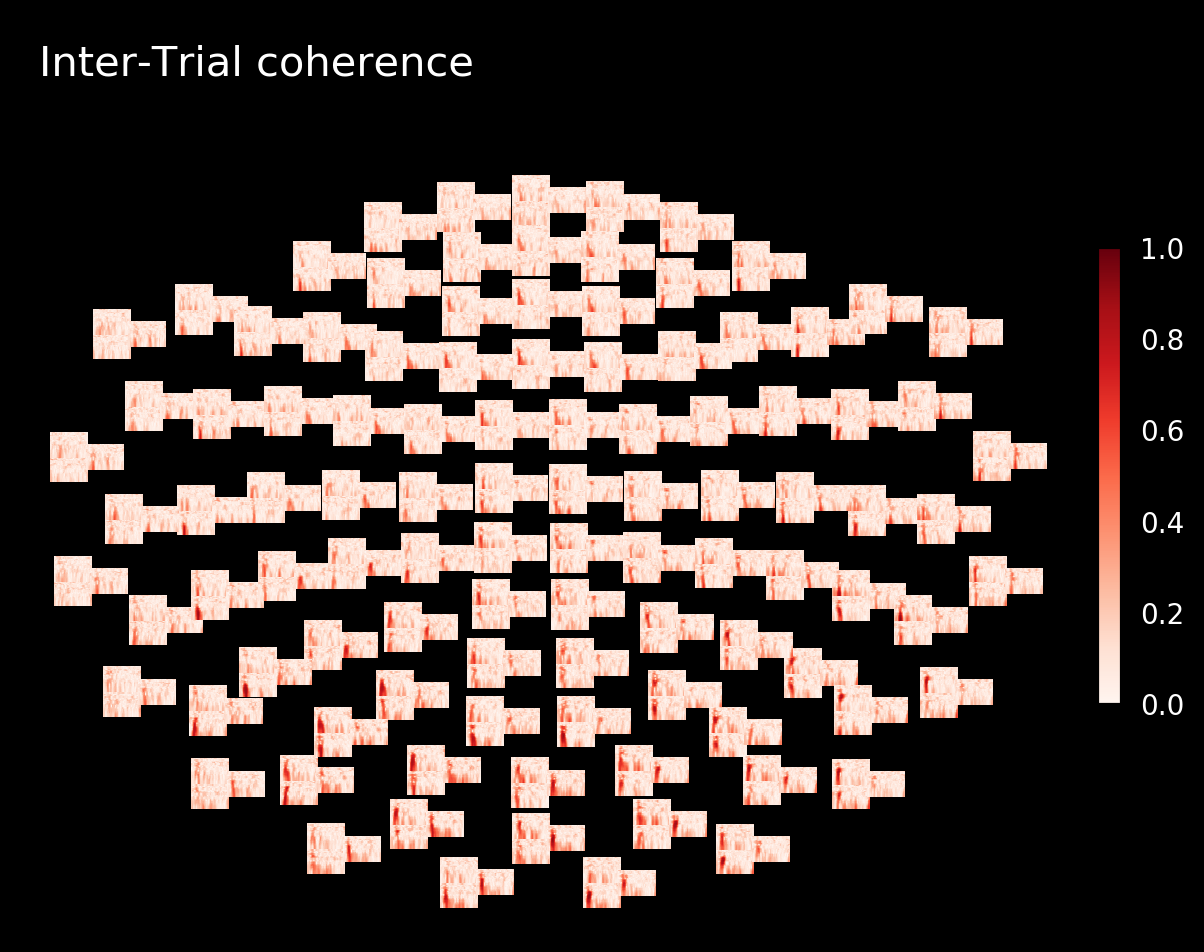

/Users/dengeman/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:216: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
/Users/dengeman/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:216: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)
/Users/dengeman/anaconda3/lib/python3.7/site-packages/matplotlib/widgets.py:2215: RuntimeWarning: Failed to locate eeg channel positions from layout. Inferring channel positions from data.
  self.onselect(self.eventpress, self.eventrelease)
/Users/dengeman/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:216: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
/Users/dengeman/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:216: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)


In [12]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds')

<div class="alert alert-info"><h4>Note</h4><p>Baseline correction can be applied to power or done in plots.
    To illustrate the baseline correction in plots, the next line is
    commented power.apply_baseline(baseline=(-0.5, 0), mode='logratio')</p></div>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Visualize the inter-trial coherence values as topomaps as done with
     power</li>
    </ul>
</div>